## Exercise 3: SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from cvxopt import matrix, solvers # Install cvxopt via "pip install cvxopt"

In [2]:
# ========================
# 1. Complete SVM implementation
# ========================

#Note for correctors: I comment more than Van Rossum would prefer, comments include links to websites. 
#This first version is a bit incosistent. I underestimated the workload a bit, so yeah...
#There are several things wrong with the code and I will be really pleased to see the solution...

class DualSVM:
    def __init__(self, C=1.0, kernel="linear", gamma=1.0):
        self.C = C # Regularization constant
        self.kernel = kernel # Kernel type: "linear" or "rbf"
        self.gamma = gamma # Kernel parameter ("bandwith")
        self.alpha = None # Lagrange multipliers
        self.sv_X = None # Support vectors
        self.sv_y = None # Support vector labels
        self.w = None # Weights
        self.b = None # Bias

    def linear_kernel(self, X1, X2) -> np.array:
        #interestingly enough, I found all kinds of versions for the linear kernel: transpoe x1. no, x2... and others didn't even bother at all
        #this version was the one that worked first, after the 1 to 1 implementation of the instructions seemed to fail. 
        return np.dot(X1,X2.T)

    def rbf_kernel(self, X1, X2):
        # there are a few ways to compute the rbf kernel, notably different are the one for vectors and for matrixes :

        
        """was the version I found first, but it failed me in task 5
        return np.exp(-self.gamma * np.linalg.norm(X1 - X2)**2)"""

        # https://github.com/xbeat/Machine-Learning/blob/main/The%20Mathematics%20of%20RBF%20Kernel%20in%20Python.md:
        X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
        X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
        dist_sq = X1_sq + X2_sq - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * dist_sq)
        

    def compute_kernel(self, X1, X2):
        if self.kernel == "linear":
            return self.linear_kernel(X1, X2)
        elif self.kernel == "rbf":
            return self.rbf_kernel(X1, X2)
        else:
            raise ValueError("Unknown kernel type.")

    def fit(self, X, y):
        #in fit, we are refering back to the dual formulation we were given at the beginning (hence optimization objective & constraints)
        n_samples, n_features = X.shape

        # Compute kernel matrix K: K[i,j] = K(x_i, x_j)
        K = self.compute_kernel(X, X)

        """
        The dual objective is:
            max  sum_i alpha_i - 1/2 sum_i sum_j alpha_i alpha_j y_i y_j K(x_i, x_j)
        subject to:
            sum_i alpha_i y_i = 0  and  0 <= alpha_i <= C for all i.
        In QP formulation:
            P = (y_i y_j K(x_i,x_j))_{i,j},   q = -1 (vector),
            A = y^T, b = 0, and G, h implement 0 <= alpha_i <= C.
        """

        #It seems to be recommemded to reshape y for cvxopt into a 2D array column vector
        Y = y.reshape(-1, 1)
        #To create the y_i * y_j matrix part of the formula, we are recommended to do 
        yiyj = np.outer(y,y)
        P = matrix(yiyj * K )
        q = matrix(-np.ones(n_samples))
        A = matrix(y.reshape(-1,1).astype("double"), (1, n_samples),"d") # Use "d" flag to make sure that the matrix is in double precision format (labels are integers)
        b = matrix(0.0)
        
        
        #after the inequality constraints in the enoncé, we require some prerequisits to do G and h
        I_minus = - np.eye(n_samples)
        I = np.eye(n_samples)

        G = matrix(np.vstack((I_minus, I)))

        zeros = np.zeros(n_samples)
        c_matrix = np.ones(n_samples) * self.C
        h = matrix(np.hstack((zeros, c_matrix)), tc="d")

        # Solve the QP problem using cvxopt
        solvers.options["show_progress"] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution["x"]) # Get optimal alphas

        # Get support vectors (i.e. data points with non-zero lagrange multipliers, that are on the margin)
        sv = alphas > 1e-5 # alpha > 1e-5 to account for numerical errors
        self.alpha = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        # The bias corresponds to the average error over all support vectors:
        # Why does the bias corresponds to the average error over all support vectors?
        # The answer is that the bias is the average of the differences between the true labels and the predicted labels
        # for the support vectors. The predicted labels are computed by the decision function f(x) = sum(alpha_i y_i K(x,x_i)) + b.
        # The difference between the true labels and the predicted labels is the error for each support vector.
        # The bias is the average of these errors.
        self.b = np.mean(self.sv_y - np.sum(self.alpha * self.sv_y * K[sv][:, sv], axis=1))


    def predict(self, X):
        y_pred = []
        for x in X:
            s = 0
            for alpha_i, y_i, x_i in zip(self.alpha, self.sv_y, self.sv_X):
                s += alpha_i * y_i * self.compute_kernel(x, x_i)
            y_pred.append(s + self.b)
        return np.sign(y_pred)


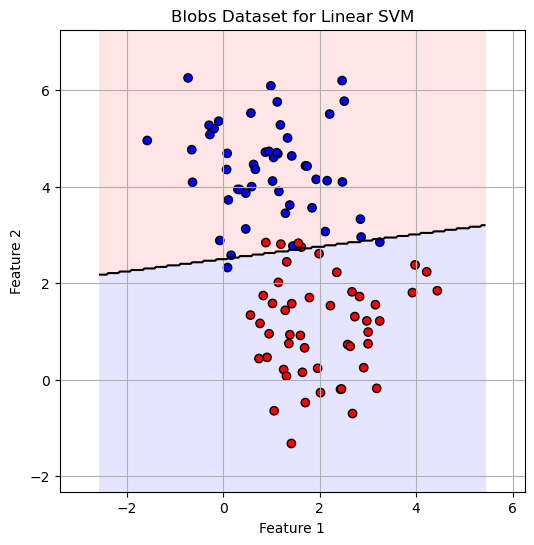

In [3]:
# ========================
# 2. Apply linear SVM on blobs
# ========================

# TODO: Generate blobs dataset
X_linear, y_linear = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=0)

# Convert labels from {0,1} to {-1,1}
y_linear = 2 * (y_linear - 0.5) 

#TODO: Train SVM with linear kernel
SVM_Linear = DualSVM()
SVM_Linear.fit(X_linear,y_linear)

#TODO: Plot decision boundary

# most of the following instructions are purely to make it prettier.
plt.figure(figsize=(6, 6))
plt.title("Blobs Dataset for Linear SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.axis("equal")

# Draw decision boundary and margin
# There are a few extra steps to making the decision boundary onto the graph: create a meshgrid, contour it (and color it in case you want it a bit more chique)
xx, yy = np.meshgrid(
    np.linspace(X_linear[:, 0].min() - 1, X_linear[:, 0].max() + 1, 300),
    np.linspace(X_linear[:, 1].min() - 1, X_linear[:, 1].max() + 1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]  # shape (300*300, 2)

# Compute predictions over the grid
Z = SVM_Linear.predict(grid).reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.3)
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.5)


plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap="bwr", edgecolors="k")
plt.show()

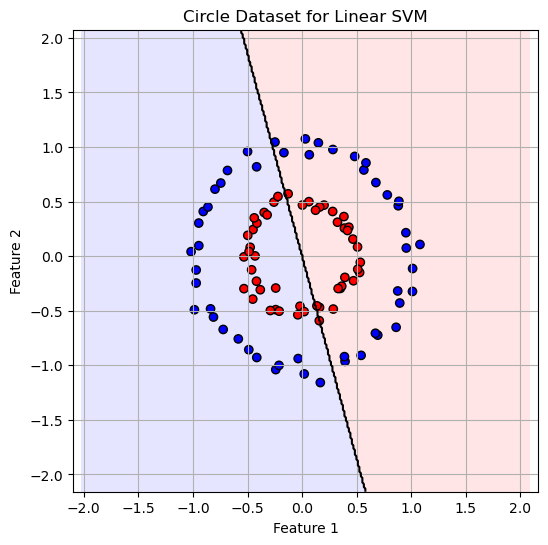

In [4]:
# ===========================
# 3. Apply linear SVM on circles
# ===========================

# TODO: Generate blobs dataset
X_circles, y_circles = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=0)
y_circles = 2 * (y_circles - 0.5)  # Convert labels from {0,1} to {-1,1}

# TODO: Train SVM with linear kernel 
SVM_Linear_Circle = DualSVM()
SVM_Linear_Circle.fit(X_circles, y_circles)

#TODO: Plot decision boundary

xx_2, yy_2 = np.meshgrid(
    np.linspace(X_circles[:, 0].min() - 1, X_circles[:, 0].max() + 1, 300),
    np.linspace(X_circles[:, 1].min() - 1, X_circles[:, 1].max() + 1, 300)
)
new_grid = np.c_[xx_2.ravel(), yy_2.ravel()]
Z_2 = SVM_Linear_Circle.predict(new_grid).reshape(xx_2.shape)

plt.figure(figsize=(6, 6))
plt.title("Circle Dataset for Linear SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.axis("equal")
plt.contourf(xx_2, yy_2, Z_2, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.3)
plt.contour(xx_2, yy_2, Z_2, levels=[0], colors='k', linewidths=1.5)

plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap="bwr", edgecolors="k")
plt.show()


In [5]:
# ===========================
# 4. Apply feature transformation 
# ===========================
def transform_features(X):
    # TODO: compute feature transformation: f(x) = [x1, x2, x1^2 + x2^2]
    x1, x2 = X_circles[:,0], X_circles[:,1]
    last = x1**2 + x2**2
    return np.column_stack([x1, x2, last])


#TODO: Train SVM with linear kernel on transformed features
SVM_Linear_Circle_tf = DualSVM()

SVM_Linear_Circle_tf.fit(transform_features(X_circles), y_circles)

def plot_decision_boundary_transformed(X, y, model, title="SVM Decision Boundary (Transformed)"):
    # TODO: Implement plotting function for decision boundary in the transformed feature space
    # Hint: You could do this by creating a 2D meshgrid which you transform using the feature mapping.
    # Then, after evaluating the model on it, you can plot the result as a contour plot (plt.contourf).

    xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300),
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_transformed = transform_features(grid) 
    Z = model.predict(grid_transformed).reshape(xx.shape) # it always fails here due to reshaping, can't seem to fix it. 
    #I know the error has to do with the transformation, but I can't seem to find the right way to do it.

    plt.figure(figsize=(6, 6))
    plt.title("Circle Dataset for Linear SVM")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.axis("equal")
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolors="k")
    plt.show()

#TODO: Plot decision boundary in the transformed feature space
plot_decision_boundary_transformed(X_circles, y_circles, SVM_Linear_Circle_tf, title="SVM Decision Boundary with Feature Transformation")

ValueError: cannot reshape array of size 100 into shape (300,300)

In [6]:
# ===========================
# 5. SVM with RBF Kernel on Circular Data
# ===========================

#TODO: Train SVM with RBF kernel on circular data
SVM_RBF = DualSVM(1., "rbf")
SVM_RBF.fit(X_circles, y_circles)




#TODO: Plot decision boundary

xx_3, yy_3 = np.meshgrid(
    np.linspace(X_circles[:, 0].min() - 1, X_circles[:, 0].max() + 1, 300),
    np.linspace(X_circles[:, 1].min() - 1, X_circles[:, 1].max() + 1, 300)
)
new_grid_2 = np.c_[xx_3.ravel(), yy_3.ravel()]
Z_3 = SVM_RBF.predict(new_grid_2).reshape(xx_3.shape) #Isn't this nice? Failing at the same place tiwce, but for different reasons.
#In this case the error is a dimension error.
plt.figure(figsize=(6, 6))
plt.title("Circle Dataset for RBF SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.axis("equal")
plt.contourf(xx_3, yy_3, Z_3, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.3)
plt.contour(xx_3, yy_3, Z_3, levels=[0], colors='k', linewidths=1.5)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap="bwr", edgecolors="k")
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

### 6.

TODO: Compare the decision boundaries from Tasks 3, 4, and 5. How does feature transformation differ from using an RBF kernel? When would one approach be preferable to the other?

//


### 7. 

TODO: Besides the dual formulation, SVMs also have an equivalent primal formulation. The key factor in choosing which one to use as the optimization criterion is the dimensionality of the features. Explain why.